# Analyzing Housing Data


Exploring a California housing data set

In [1]:
# import stuff
import os
import tarfile
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn import model_selection 


## Retrieve

In [2]:
# remote data source(s)
path_remote = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/"
path_remote_housing = path_remote + "housing/housing.tgz"

# define local data path 
path_local_housing = os.path.join("datasets", "housing")

In [3]:
# fetch data (tgz format)
def fetch_data_tgz(remote, local, filename):
    os.makedirs(local, exist_ok = True)
    tgz_path = os.path.join(local, filename)
    urllib.request.urlretrieve(remote, tgz_path)
    tgz_file = tarfile.open(tgz_path)
    tgz_file.extractall(path=local)
    tgz_file.close()
    
fetch_data_tgz(path_remote_housing, path_local_housing, 'housing.tgz')

In [4]:
# load dataframe (pandas)
def load_data_csv(path, filename_csv):
    csv_path = os.path.join(path, filename_csv)
    return pd.read_csv(csv_path)
    
housing = load_data_csv(path_local_housing, 'housing.csv')    


## Explore

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


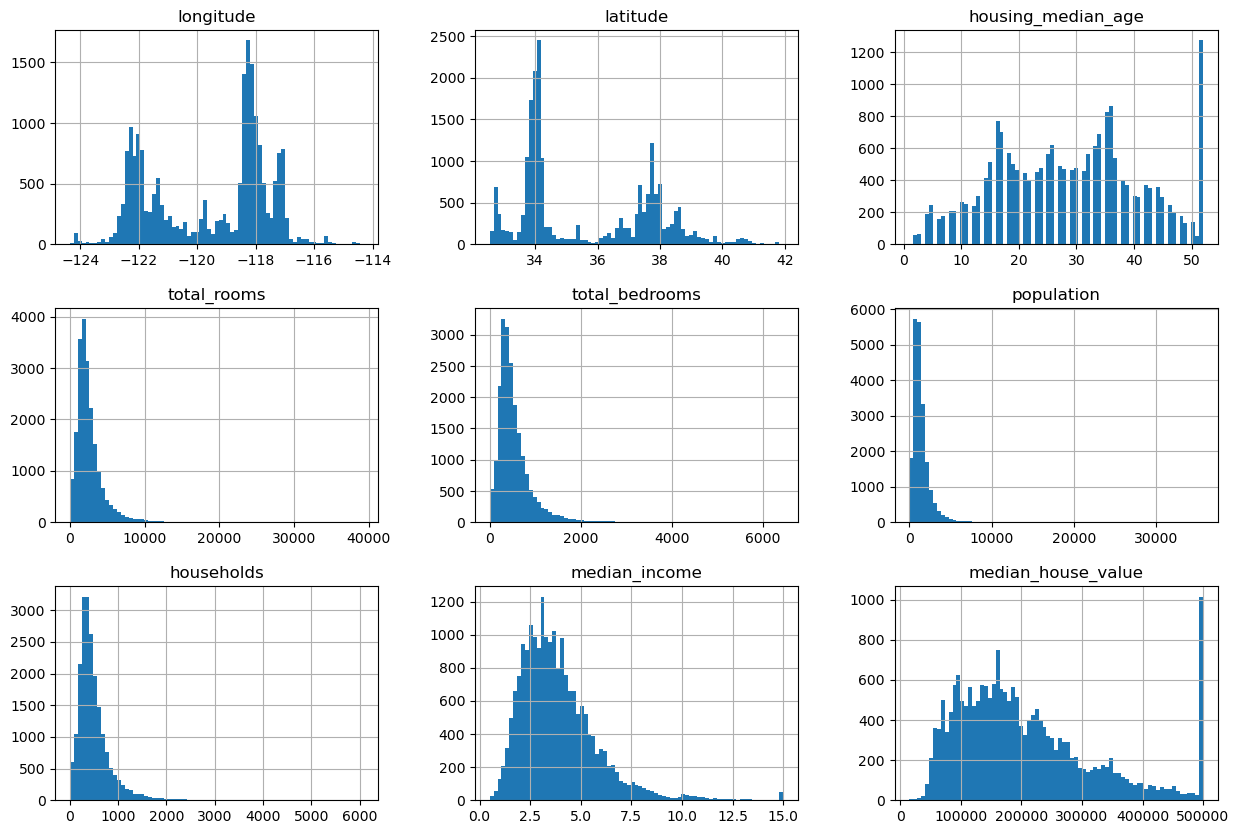

In [8]:
# plot a histogram (can be done on dataframe directly)
%matplotlib inline
housing.hist(bins=75, figsize=(15,10))
plt.show()

## Prepare

In [9]:
# split into train/test set
test_ratio = 0.2
random_seed = 42

# just a simple split (not used)
def split_data(data, test_ratio):
    if test_ratio <= 0 or test_ratio >= 1:
        raise ValueError("Select 0 < test ratio < 1")
    train_length = len(data) - int(test_ratio*len(data))
    shuffled_indices = np.random.permutation(len(data))
    train_indices = shuffled_indices[:train_length]
    test_indices = shuffled_indices[train_length:]
    return data.iloc[train_indices], data.iloc[test_indices]

# using sklearn
#train_set, test_set = model_selection.train_test_split(housing, test_size = test_ratio, random_state = random_seed)


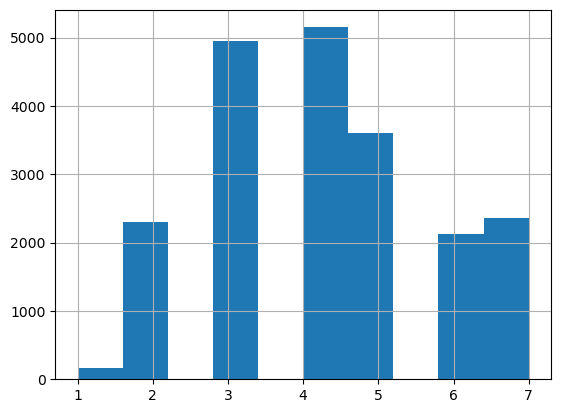

In [10]:
# lets look for imbalance in the dataset (heuristics tell us median income is important
housing['income_category'] = pd.cut(housing['median_income'], bins=[0.,1.,2.,3.,4.,5.,6.,np.inf],labels=[1,2,3,4,5,6,7])
%matplotlib inline
housing['income_category'].hist()
plt.show()

In [11]:
# we see some imbalance here, so let's try a stratified split
Split = model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = test_ratio, random_state = random_seed)
for i, j in Split.split(housing, housing['income_category']):
    train_set_stratified = housing.loc[i]
    test_set_stratified = housing.loc[j]

# compare
train_set_rand, test_set_rand = split_data(housing, test_ratio)
counts_rand = test_set_rand['income_category'].value_counts()/len(test_set_rand)
counts_strat = test_set_stratified['income_category'].value_counts()/len(test_set_stratified) 
counts_overall = housing['income_category'].value_counts()/len(housing)    
    
errors_rand = 100*(counts_overall - counts_rand)/counts_overall    
errors_strat = 100*(counts_overall - counts_strat)/counts_overall
    
comparison_table = pd.DataFrame({
    'Random Split Error (%)': errors_rand,
    'Stratified Split Error (%)': errors_strat
})

print(comparison_table.sort_index())

   Random Split Error (%)  Stratified Split Error (%)
1                5.660377                   -0.628931
2                2.306353                   -0.087032
3               -2.911444                    0.020218
4                2.427184                    0.000000
5                2.723735                   -0.055586
6                0.564175                    0.094029
7               -6.477561                    0.084674


In [12]:
# we no longer need that income category
for each_set in (train_set_stratified, test_set_stratified):
    each_set.drop('income_category', axis = 1, inplace = True)

## Visualize 

Here we scatter plot the house value by lattitude and longitude, with the size of the dot scaling by population and a heat map of house value. 

Big cities by the coast are expensive.

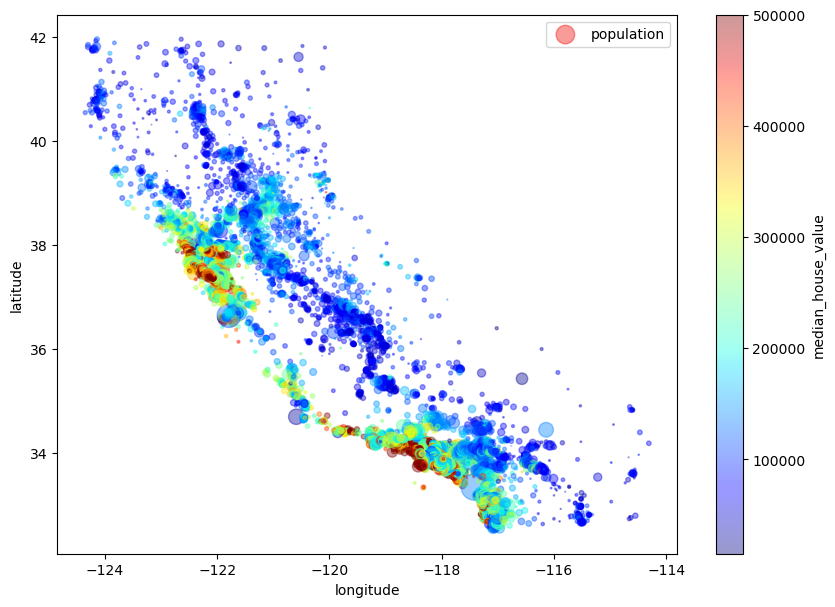

In [16]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha = 0.4, s = housing['population']/100, label = 'population', figsize = (10,7), c= 'median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

KeyError: 'median_age'

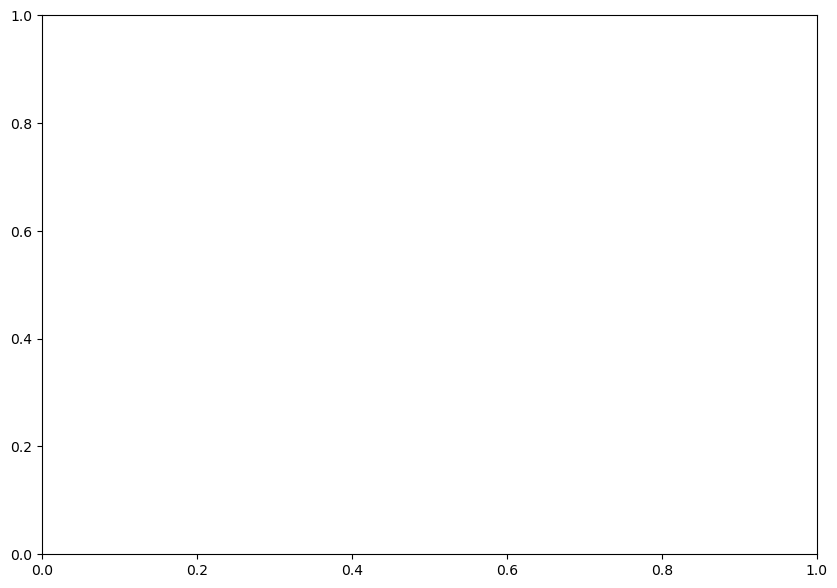

In [17]:
housing.plot(kind='scatter', x='median_age', y='median_house_value', alpha = 0.4, s = housing['population']/100, label = 'population', figsize = (10,7), c= 'median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()